In [2]:
import requests
import json 
import matplotlib.pyplot as plt

def getpath(nested_dict, value, prepath=()):
    for k, v in nested_dict.items():
        path = prepath + (k,)
        if v == value: # found value
            return path
        elif hasattr(v, 'items'): # v is a dict
            p = getpath(v, value, path) # recursive call
            if p is not None:
                return p

SLEEPER_ID = 802628454850875392
BASE_SLEEPER_URL = "https://api.sleeper.app/v1"
HIDDEN_SLEEPER_URL = "https://api.sleeper.app"

# retrieve all players
res = requests.get(BASE_SLEEPER_URL + "/players/nfl")
all_players = json.loads(res.text)

# retrieve managers
res = requests.get(BASE_SLEEPER_URL + "/league/{}/users".format(SLEEPER_ID))
response = json.loads(res.text)

users = []
for r in response:
    try:
        users.append({
            'user_id': r['user_id'],
            'user_name': r['display_name'],
            'team_name': r['metadata']['team_name']
        })
    except KeyError:
        users.append({
            'user_id': r['user_id'],
            'user_name': r['display_name'],
            'team_name': r['display_name']
        })

In [3]:

# get draft picks
draft_2020_names = ["Jonathan Taylor","Clyde Edwards-Helaire","J.K. Dobbins","CeeDee Lamb","Cam Akers","Swift","Justin Jefferson","Jerry Jeudy","Henry Ruggs","Brandon Aiyuk","Jalen Reagor","Tee Higgins","Joe Burrow","Ke'Shawn Vaughn","Michael Pittman","Denzel Mims","AJ Dillon","Bryan Edwards","Zack Moss","Chase Claypool","Laviska Shenault","Tua Tagovailoa","Devin Duvernay","Anthony McFarland","Darrynton Evans","K.J. Hamler","Cole Kmet","Justin Herbert","Jack Doyle","Antonio Gibson","Van Jefferson","Gandy-Golden"]
draft_2020_data = []
draft_2021_names = ["Najee Harris","Ja'Marr Chase","Kyle Pitts","Travis Etienne","Javonte Williams","Trevor Lawrence","Jaylen Waddle","DeVonta Smith","Elijah Moore","Trey Sermon","Michael Carter","Trey Lance","Justin Fields","Terrace Marshall","Rashod Bateman","Rondale Moore","Joshua Palmer","Amon-Ra St. Brown","Kadarius Toney","Zach Wilson","Dyami Brown","Tutu Atwell","Kenneth Gainwell","Mac Jones","Chuba Hubbard","Pat Freiermuth","Rhamondre Stevenson","Nico Collins","","Anthony Schwartz","Amari Rodgers","Hunter Henry"]
draft_2021_data = []
draft_2022_names = ["Breece Hall","Kenneth Walker","Jameson Williams","Drake London","Chris Olave","Garrett Wilson","Jahan Dotson","Treylon Burks","Skyy Moore","George Pickens","James Cook","Christian Watson","Rachaad White","Isaiah Spiller","Kenny Pickett","Alec Pierce","David Bell","Jalen Tolbert","John Metchie","Dameon Pierce","Trey McBride","Brian Robinson","Tyquan Thornton","Khalil Shakir","Wan'Dale Robinson","Greg Dulcich","Malik Willis","Tyler Allgeier","Desmond Ridder","Romeo Doubs","Jelani Woods","Calvin Austin","Kyren Williams","Hassan Haskins","Tyrion Davis-Price","Daniel Bellinger","Sam Howell","Zamir White","Taysom Hill","Brock Purdy","Matt Corral","Brevin Jordan","Velus Jones","Pierre Strong","Justyn Ross","Nick Westbrook-Ikhine","","Gerald Everett"]
draft_2022_data = []

def get_draft_data(player_names, player_data):
    years = [2022,2021,2020,2019]
    idx = 1
    for name in player_names:
        player_id = getpath(all_players, name)[0]
        total_fpts = 0
        for year in years:
            try:
                res = requests.get(HIDDEN_SLEEPER_URL + "/stats/nfl/player/{}?season_type=regular&season={}".format(player_id, year))
                response = json.loads(res.text)
                total_fpts = total_fpts + response['stats']['pts_half_ppr']
            except:
                break

        player_data.append({
            'id': player_id,
            'name': name,
            'draft_pos': idx,
            'total_fpts': total_fpts,
            # TODO: add who player was drafted_by
        })
        idx = idx + 1

get_draft_data(draft_2020_names, draft_2020_data)
get_draft_data(draft_2021_names, draft_2021_data)
get_draft_data(draft_2022_names, draft_2022_data)


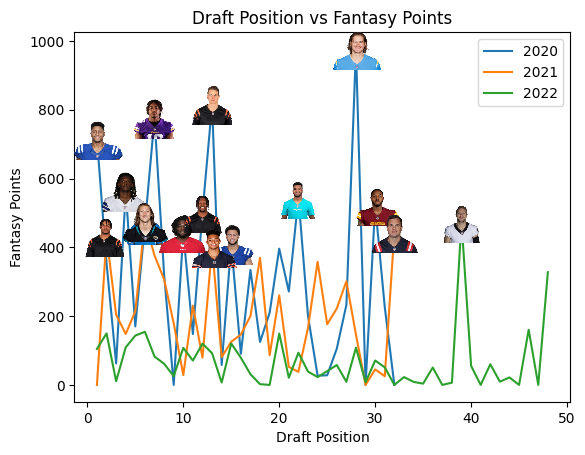

In [23]:
# plot the data
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import PIL
import urllib

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

fig, ax = plt.subplots()
def plot_draft_pos_data(data, year):
    x = []
    y = []
    for d in data:
        x.append(d['draft_pos'])
        y.append(d['total_fpts'])

        if d['total_fpts'] > 400:
            url = 'https://sleepercdn.com/content/nfl/players/{}.jpg'.format(d['id'])
            image = PIL.Image.open(urllib.request.urlopen(url))
            image.save('images/{}.png'.format(d['id']))
            imscatter(d['draft_pos'], d['total_fpts'], 'images/{}.png'.format(d['id']), zoom=0.15, ax=ax)

    ax.plot(x, y, label=year)
    plt.xlabel('Draft Position')
    plt.ylabel('Fantasy Points')
    plt.title('Draft Position vs Fantasy Points')
    plt.legend()

plot_draft_pos_data(draft_2020_data, '2020')
plot_draft_pos_data(draft_2021_data, '2021')
plot_draft_pos_data(draft_2022_data, '2022')

plt.show()
